In [3]:
# Some useful settings for interactive work
%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import plotters as pt
import os 
import pickle
import numpy as np


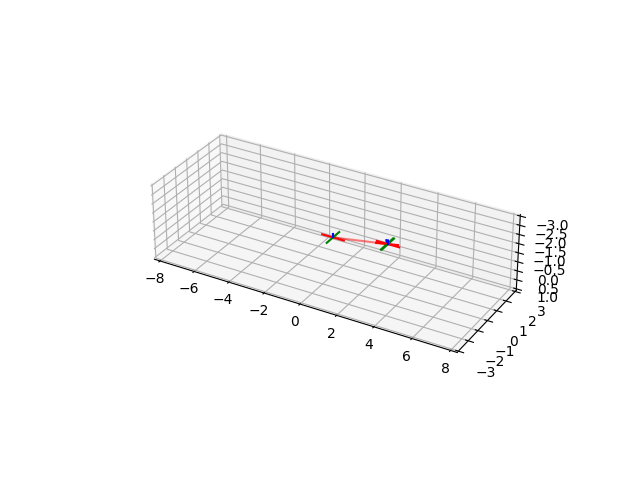

In [5]:

data_path = os.path.join("data","ascend"+".pkl")

# Load Flight Data
with open(data_path,'rb') as file:
    idl_data = pickle.load(file)

Ti:np.ndarray   = idl_data['Ti']
FOi:np.ndarray  = idl_data['FOi']
tXUi:np.ndarray = idl_data['tXUi']
Ci:np.ndarray   = idl_data['Ci']

pt.tXU_to_3D([tXUi])


In [6]:
def train_loop(model, opt, loss_fn, dataloader):
    """
    Method from "A detailed guide to Pytorch's nn.Transformer() module.", by
    Daniel Melchor: https://medium.com/@danielmelchor/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
    """
    
    model.train()
    total_loss = 0
    
    for batch in dataloader:
        X, y = batch[:, 0], batch[:, 1]
        X, y = torch.tensor(X).to(device), torch.tensor(y).to(device)

        # Now we shift the tgt by one so with the <SOS> we predict the token at pos 1
        y_input = y[:,:-1]
        y_expected = y[:,1:]
        print(X.shape, y_input.shape, y_expected.shape)
        # Standard training except we pass in y_input and tgt_mask
        pred = model(X, y_input)

        # Permute pred to have batch size first again
        pred = pred.permute(1, 2, 0)      
        loss = loss_fn(pred, y_expected)

        opt.zero_grad()
        loss.backward()
        opt.step()
    
        total_loss += loss.detach().item()
        
    return total_loss / len(dataloader)

def validation_loop(model, loss_fn, dataloader):
    """
    Method from "A detailed guide to Pytorch's nn.Transformer() module.", by
    Daniel Melchor: https://medium.com/@danielmelchor/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
    """
    
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for batch in dataloader:
            X, y = batch[:, 0], batch[:, 1]
            X, y = torch.tensor(X, dtype=torch.long, device=device), torch.tensor(y, dtype=torch.long, device=device)

            # Now we shift the tgt by one so with the <SOS> we predict the token at pos 1
            y_input = y[:,:-1]
            y_expected = y[:,1:]
            
            # Standard training except we pass in y_input and src_mask
            pred = model(X, y_input)

            # Permute pred to have batch size first again
            pred = pred.permute(1, 2, 0)      
            loss = loss_fn(pred, y_expected)
            total_loss += loss.detach().item()
        
    return total_loss / len(dataloader)


def fit(model, opt, loss_fn, train_dataloader, val_dataloader, epochs):
    """
    Method from "A detailed guide to Pytorch's nn.Transformer() module.", by
    Daniel Melchor: https://medium.com/@danielmelchor/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
    """
    
    # Used for plotting later on
    train_loss_list, validation_loss_list = [], []
    
    print("Training and validating model")
    for epoch in range(epochs):
        print("-"*25, f"Epoch {epoch + 1}","-"*25)
        
        train_loss = train_loop(model, opt, loss_fn, train_dataloader)
        train_loss_list += [train_loss]
        
        validation_loss = validation_loop(model, loss_fn, val_dataloader)
        validation_loss_list += [validation_loss]
        
        print(f"Training loss: {train_loss:.4f}")
        print(f"Validation loss: {validation_loss:.4f}")
        print()
        
    return train_loss_list, validation_loss_list
    